In [888]:
include("../../Ofdm.jl");
include("../../../../Channel/Channel.jl")
include("../../../../../SignalProcessing/CompressedSensing/Greedy.jl")

Main.Greedy

In [889]:
using FFTW, Plots, LinearAlgebra, StatsBase

In [890]:
nbits=1000; M=4; qam = Ofdm.QamMod(M);
nfft=64;cpsize=32;ndim=(1,1)

(1, 1)

In [891]:
params = Ofdm.OfdmParams(nfft,cpsize,28,4,(1,1), pilot_type=:comb,pilot_space=2,pilot_interval=1);
indices = Ofdm.get_index(params);
indices[:pilot] = sort!(sample(1:64, 16, replace=false))
# indices[:pilot] = sort!(sample(indices[:pilot], 28, replace=false))

16-element Array{Int64,1}:
  4
  5
  6
 23
 28
 33
 39
 44
 47
 48
 49
 52
 53
 54
 55
 57

In [892]:
pilot_bit = rand(128) .> 0.5
pilot_symbol = Ofdm.qammod(qam, pilot_bit)
pilot_symbol[setdiff(1:64,1:4:64)] .= 0

48-element view(::Array{Complex{Float64},1}, [2, 3, 4, 6, 7, 8, 10, 11, 12, 14  …  52, 54, 55, 56, 58, 59, 60, 62, 63, 64]) with eltype Complex{Float64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮      
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [893]:
frame = Ofdm.gen_frame(params,indices,1);
pdp = Channel.uniform(4,9,32);
L = size(pdp,1)
F = fft(Array{ComplexF64}(I,nfft,nfft), 1); # DFT行列

In [894]:
nonzero = findall(x-> abs(x)>0, pdp[:]);
pind = indices[:pilot]

16-element Array{Int64,1}:
  4
  5
  6
 23
 28
 33
 39
 44
 47
 48
 49
 52
 53
 54
 55
 57

In [895]:
tx_sig = ifft(frame, 1);
tx_sig = [tx_sig[end-cpsize+1:end]; tx_sig] .* sqrt(nfft);
rx_sig, cir = Channel.multipath_fading(tx_sig, ndim, pdp, istail=false);
rx_frame = fft(view(rx_sig,cpsize+1:cpsize+nfft),1) ./ sqrt(nfft);
# rx_frame[1:4:64] ./= pilot_symbol[1:4:64]
rx_frame[pind] ./=  frame[pind]

16-element view(::Array{Complex{Float64},1}, [4, 5, 6, 23, 28, 33, 39, 44, 47, 48, 49, 52, 53, 54, 55, 57]) with eltype Complex{Float64}:
  -1.5247164982647794 - 0.34540945971799314im
  -0.3261953505027789 - 0.21346389440844107im
    -0.51748182257315 - 0.09094862516686389im
  -0.3962213070271966 + 0.7050773052136101im 
  0.21605675319905446 - 0.23729339257654172im
  -0.6833455973949882 + 0.12271649007802705im
  -1.2731508112477894 - 1.6340427759912484im 
   -1.192182160797033 + 0.2711113620949906im 
  -1.0421378957365683 + 0.09613326275491792im
 -0.42544972764584105 - 0.4101569619064995im 
  -0.1731440661990551 + 0.01596825945813439im
   0.9272167208547469 - 0.10568041509505006im
  -0.7300464198782167 - 1.9530327317338796im 
  -1.2266883197295944 + 0.00257484008114116im
  -0.3700377824802252 - 0.3715055304296163im 
  0.09018554223086667 - 1.145947422952803im  

In [896]:
# A = diagm(frame[pind])*F[pind,1:L]
A = F[pind,1:L]

16×28 Array{Complex{Float64},2}:
 1.0+0.0im     0.95694-0.290285im  …  -0.0980171-0.995185im 
 1.0+0.0im     0.92388-0.382683im      -0.382683+0.92388im  
 1.0+0.0im    0.881921-0.471397im        0.77301-0.634393im 
 1.0+0.0im    -0.55557-0.83147im        -0.19509-0.980785im 
 1.0+0.0im   -0.881921-0.471397im       -0.77301-0.634393im 
 1.0+0.0im        -1.0+0.0im       …        -1.0+0.0im      
 1.0+0.0im    -0.83147+0.55557im        0.980785-0.19509im  
 1.0+0.0im   -0.471397+0.881921im       0.634393-0.77301im  
 1.0+0.0im    -0.19509+0.980785im       -0.83147-0.55557im  
 1.0+0.0im  -0.0980171+0.995185im       0.471397+0.881921im 
 1.0+0.0im         0.0+1.0im       …         0.0-1.0im      
 1.0+0.0im    0.290285+0.95694im       -0.995185+0.0980171im
 1.0+0.0im    0.382683+0.92388im         0.92388+0.382683im 
 1.0+0.0im    0.471397+0.881921im      -0.634393-0.77301im  
 1.0+0.0im     0.55557+0.83147im         0.19509+0.980785im 
 1.0+0.0im    0.707107+0.707107im  …   -0.707107+0.7

In [897]:
cir_est, S, iter= Greedy.omp(view(rx_frame,pind), A, 1e-3, L) 

ik = 1
S = [1]
norm(r) = 3.6422433115778223
ik = 19
S = [1, 19]
norm(r) = 2.746241403834017
ik = 28
S = [1, 19, 28]
norm(r) = 0.8926214333288752
ik = 10
S = [1, 19, 28, 10]
norm(r) = 2.715538256972495e-15


(Complex{Float64}[-0.43437745404204003 - 0.5212365049940562im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.24038824626801236 + 0.0107466813148408im  …  -0.6160380804069318 + 0.3106416651378172im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, -0.6074581833219955 - 0.3440580112491061im], [1, 19, 28, 10], 4)

In [898]:
nonzero

4-element Array{Int64,1}:
  1
 10
 19
 28

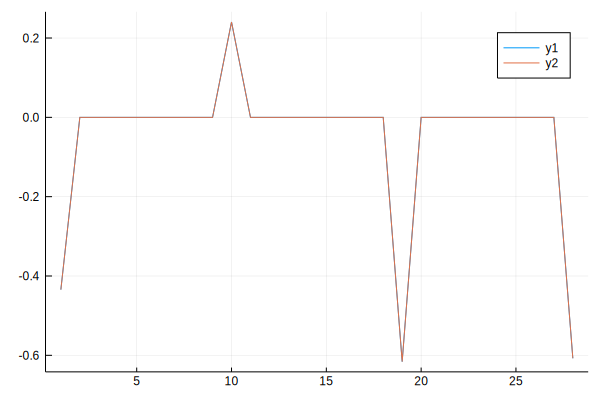

In [899]:
plot(real(cir[:]))
plot!(real(cir_est[:]))


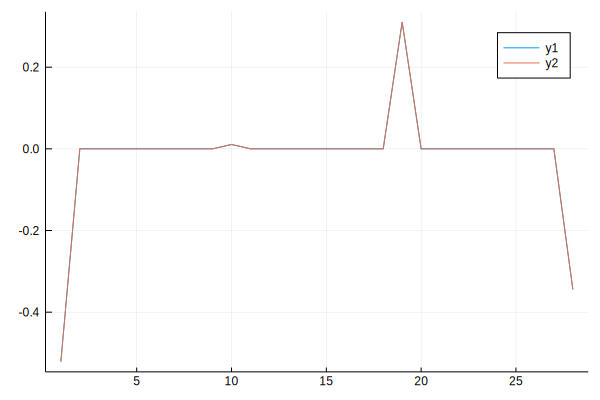

In [900]:
plot(imag(cir[:]))
plot!(imag(cir_est[:]))

In [608]:
cir_est = pinv(A) * view(rx_frame,pind)

16-element Array{Complex{Float64},1}:
   -0.04231058404671738 - 0.26083578160715704im 
   0.008899400810298302 - 0.0692886670054608im  
    0.07151735114315799 + 0.13217777503037773im 
   0.007355078905487436 + 0.11114398654419935im 
  -0.008170824984883127 - 0.06739910188238298im 
   -0.07198606088601248 - 0.1723812733205508im  
   0.017225507351879374 - 0.04420754887647434im 
     0.0415680084915373 + 0.05902347011662048im 
    0.06095934343628867 + 0.0765480759708631im  
   0.037780284777055556 - 0.05284942420738915im 
   0.055599285543685366 - 0.01611382669924183im 
    0.01192619751520621 + 0.009427075312750582im
   -0.05653007960284165 + 0.09023668604984257im 
  -0.026446962305563496 + 0.06399270621823644im 
 -0.0038876276249884267 + 0.08217223172595549im 
 -0.0032941327438822388 - 0.053147243420342376im

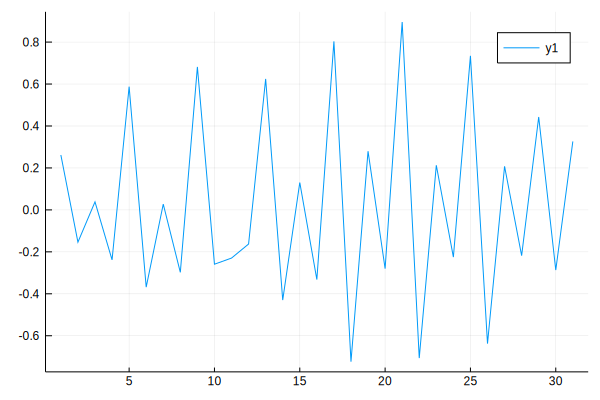

In [419]:
plot(real(cir_est))

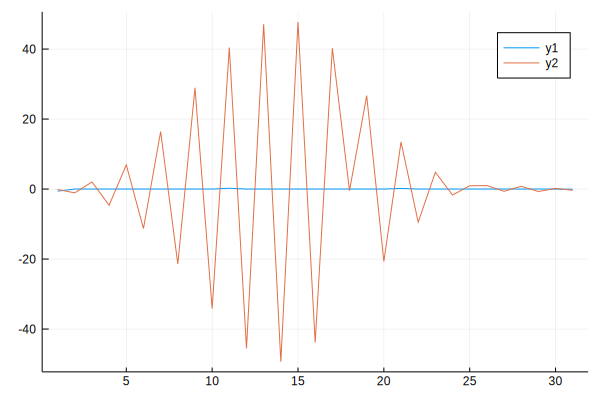

In [376]:
plot(real(cir[:]))
plot!(real(cir_est))

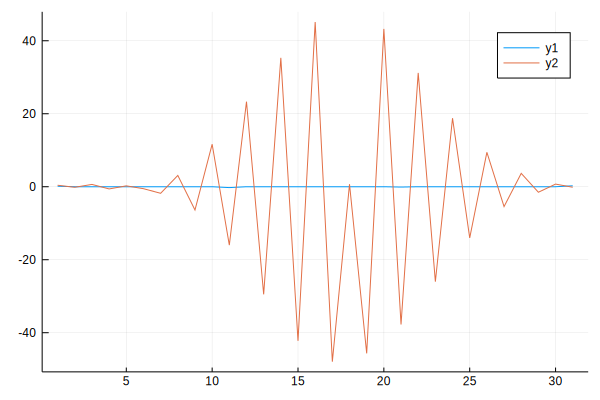

In [377]:
plot(imag(cir[:]))
plot!(imag(cir_est))

In [295]:
norm(cir[:]-cir_est).^2

0.5578293261075551

In [50]:
dot(view(rx_frame,pind),view(rx_frame,pind))

5.370390144101622 + 0.0im

In [109]:
F = fft(Array{ComplexF64}(I,nfft,nfft), 1)
A = diagm(frame[pind])*F[pind,1:L]
cir_est = zeros(eltype(cir), size(cir))
cir_est[nonzero] = pinv(A)*rx_frame[pind]

DimensionMismatch: DimensionMismatch("tried to assign 31 elements to 4 destinations")

In [796]:
cor = abs2.(A'*rx_frame[pind]) ./ sqrt.(sum(abs2.(A), dims=1))'

31×1 Array{Float64,2}:
  3.2836688231162956   
  0.012548636653183839 
  0.012379847488787865 
  0.02556961521185889  
  0.5540918316169883   
  0.09511902792125758  
  0.056824921892180094 
  0.010897299661784413 
  0.001927316409487955 
  0.01596236989745709  
  2.545670125222369    
  0.010794065217078543 
  0.0007387455300648021
  ⋮                    
  0.02556961521185889  
  0.5540918316169883   
  0.09511902792125757  
  0.056824921892180094 
  0.010897299661784416 
  0.001927316409487955 
  0.015962369897457085 
  2.545670125222369    
  0.01079406521707856  
  0.0007387455300648021
  0.00806255639851543  
 22.569637279551653    

In [797]:
sortperm(cor[:], rev=true)

31-element Array{Int64,1}:
 15
 31
  1
 17
 11
 27
  5
 21
  6
 22
  7
 23
  4
  ⋮
 19
 24
  8
 28
 12
 14
 30
 16
  9
 25
 13
 29

In [799]:
nonzero

4-element Array{Int64,1}:
  1
 11
 21
 31

In [760]:
cir_est = zeros(eltype(cir), size(cir))
cir_est[nonzero] = (A'A)\A'*rx_frame[pind]

SingularException: SingularException(31)

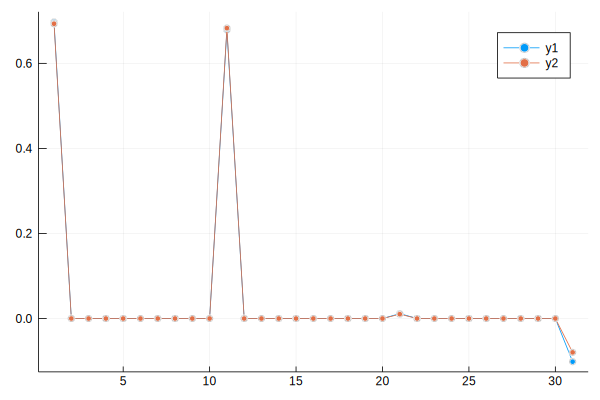

In [688]:
plot(real(cir[:]), markershape=:circle)
plot!(real(cir_est[:]), markershape=:circle)

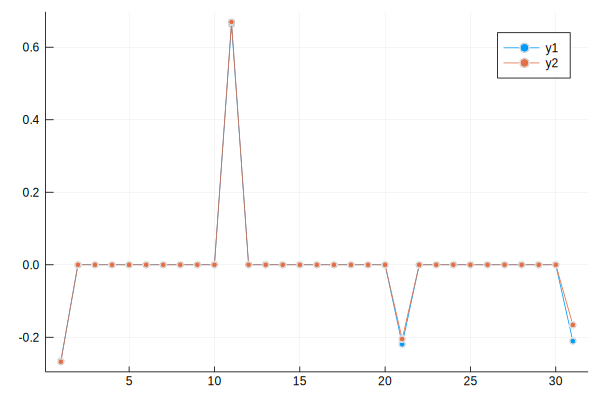

In [689]:
plot(imag(cir[:]), markershape=:circle)
plot!(imag(cir_est[:]), markershape=:circle)

In [710]:
A'*A

31×31 Array{Complex{Float64},2}:
         16.0+0.0im          …   2.22045e-16+4.44089e-16im
          0.0+4.44089e-16im      2.22045e-16-4.44089e-16im
 -2.22045e-16-4.44089e-16im      4.34576e-16+2.22045e-16im
 -2.22045e-16-0.0im             -4.44089e-16-4.44089e-16im
  2.77556e-16-0.0im             -2.22045e-16+4.44089e-16im
 -2.77556e-17-1.11022e-16im  …   2.22045e-16-4.44089e-16im
 -2.22045e-16-5.55112e-17im      1.33227e-15+0.0im        
  1.11022e-16-8.32667e-17im      5.55112e-17+2.22045e-16im
          0.0-0.0im                      0.0+0.0im        
 -1.38778e-16+1.11022e-16im              0.0-2.77556e-17im
  2.22045e-16-2.22045e-16im  …           0.0+0.0im        
          0.0-2.77556e-17im      1.11022e-16+5.55112e-17im
          0.0+2.77556e-16im      1.66533e-16-2.22045e-16im
             ⋮               ⋱              ⋮             
          0.0-2.22045e-16im      4.44089e-16-4.44089e-16im
          0.0+2.77556e-16im  …  -4.44089e-16-2.22045e-16im
          0.0-0.0im    

16×31 Array{Complex{Float64},2}:
 1.0+0.0im    0.995185-0.0980171im  …  -0.980785-0.19509im 
 1.0+0.0im    0.881921-0.471397im       -0.55557-0.83147im 
 1.0+0.0im    0.634393-0.77301im         0.19509-0.980785im
 1.0+0.0im    0.290285-0.95694im         0.83147-0.55557im 
 1.0+0.0im  -0.0980171-0.995185im       0.980785+0.19509im 
 1.0+0.0im   -0.471397-0.881921im   …    0.55557+0.83147im 
 1.0+0.0im    -0.77301-0.634393im       -0.19509+0.980785im
 1.0+0.0im    -0.95694-0.290285im       -0.83147+0.55557im 
 1.0+0.0im   -0.995185+0.0980171im     -0.980785-0.19509im 
 1.0+0.0im   -0.881921+0.471397im       -0.55557-0.83147im 
 1.0+0.0im   -0.634393+0.77301im    …    0.19509-0.980785im
 1.0+0.0im   -0.290285+0.95694im         0.83147-0.55557im 
 1.0+0.0im   0.0980171+0.995185im       0.980785+0.19509im 
 1.0+0.0im    0.471397+0.881921im        0.55557+0.83147im 
 1.0+0.0im     0.77301+0.634393im       -0.19509+0.980785im
 1.0+0.0im     0.95694+0.290285im   …   -0.83147+0.55557im 